# Monte Carlo

In [144]:
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

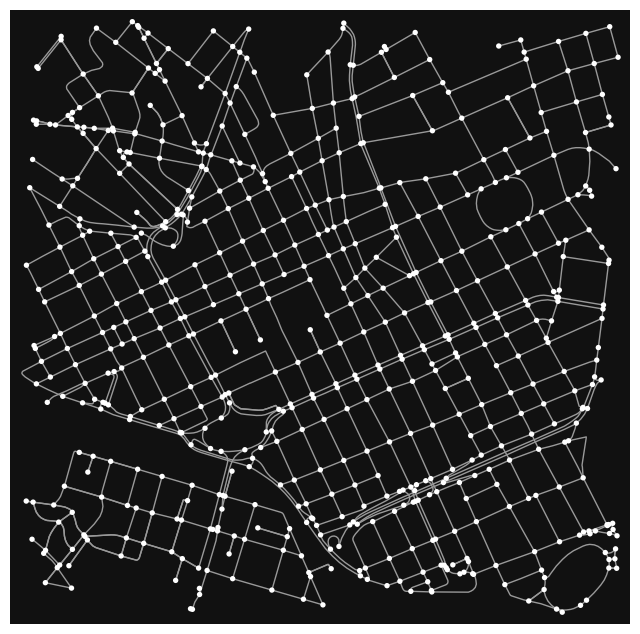

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)

In [93]:
class Environment:
  """
  Simulation of graph route that can be deterministic and stochastic.
  The main functionalities is to reset the simulation and returns the state based in the action.
  """

  def __init__(self, G, source, target, reward="weighted", mode="deterministic"):
    self.G = G
    self.max_weight = max([G[u][v][0]["length"] for u, v, m in G.edges if m == 0])
    self.source = source
    self.target = target
    self.reward = reward
    if mode == "deterministic":
        self.step = self.step_deterministic
    elif mode == "stochastic":
        self.step = self.step_stochastic

  def get_n_states(self):
    """Get number of states"""
    return len(self.G.nodes)

  def reset(self):
    """Return to the source state that is not the destination"""
    self.state = self.source
    # self.state = np.random.choice(list(self.G.nodes))
    # while self.state == self.target:
        # self.state = np.random.choice(list(self.G.nodes))
    return self.state

  def step_deterministic(self, action):
    """Return new state, reward, and if simulation is done"""

    # if is not the target, and the action is to stay in the same node
    if (action == self.state) & (action != self.target):
      return self.state, -1, False
    
    # if reached the target
    if self.state == self.target:
      return self.state, 10000, True
    

    
    # weight of the edge
    w = self.G[self.state][action][0]["length"] / self.max_weight
    # now, the state is the next node
    self.state = action

    # if the action leaves to a dead end
    neighbors = list(self.G.neighbors(self.state))
    if len(neighbors) == 0:
      return self.state, -1000, True

    if self.reward == "unit":
        return self.state, 0, False
    elif self.reward == "weighted":
        return self.state, -w, False

In [94]:
def argmax(Q, s):
  """Function to get the action with the highest value in a given state"""
  # pares estado-ação que tem estado = s
  pares = list(filter(lambda step: step[0] == s, list(Q.keys())))
  sub_Q = {k:v for k,v in Q.items() if k in pares}

  top_value = float("-inf")
  ties = []

  for i in sub_Q.items():
      # if a value in q_values is greater than the highest value update top
      if i[1] > top_value:
        top_value = i[1]

  # if a value is equal to top value add to ties
  ties = list(filter(lambda step: step[1] == top_value, list(sub_Q.items())))

  if len(ties)> 0:
    # chose the random index of the ties
    chosen = np.random.choice(range(len(ties)))
  else:
    return 0, False

  return ties[chosen][0][1], True

In [103]:
class MCAgent:
  def __init__(
      self, 
      env, 
      gamma=0.99, 
      n_episodes=1000, 
      max_steps=1000,
      
      seed = 42
    ):
    self.env = env
    self.Q = {}
    self.gamma = gamma
    self.n_episodes = n_episodes
    self.max_steps = max_steps
    self.max_epsilon = 1
    self.min_epsilon = 0.1
    self.epsilon = self.max_epsilon
    self.seed = seed
    self.set_seed()
    self.policy = {}
    self.routes = []

  def update_epsilon(self):
    # make it decay exponentially
    self.epsilon -= (self.max_epsilon - self.min_epsilon )/ self.n_episodes

  def set_seed(self):
    random.seed(self.seed)
    np.random.seed(self.seed)


  def step(self, state):
    """Returns the next action epsilon greedily using value function."""
    if np.random.uniform(0, 1) < self.epsilon: # explore
      neighbors = list(self.env.G.neighbors(state)) #+ [state]
      return random.choice(neighbors)
    else: # exploit
      action, got_it = argmax(self.Q, state)
      if got_it is False: # if not possible to chose the best action, chose randomly
        neighbors = list(self.env.G.neighbors(state)) #+ [state]
        return random.choice(neighbors)
      else: 
        return int(action)

  def generate_episode(self, observation):
    """Returns the list with state, action and rewards of the episode"""
    # it initializes list of tuples (state, action and reward)
    episode = []
    state = observation
    
    for step in range(self.max_steps):
      action = self.step(state) # select an action
      new_state, reward, done = self.env.step(action) # take action      
      episode.append((state, action, reward))
      state = new_state

      if done is True: # if end simulation, break
        self.routes = []
        route = [observation] + [i[1] for i in episode]
        if route[-1] != self.env.target:
          if len(route) > 5:
            print(f"Reached in route of size {len(route)}")
          else:
            print(f"Reached {route}")
      
          self.routes.append([route])
        break

    self.evaluation(episode)
    return episode


  def evaluation(self, episode):
    G = 0

    for i in range(len(episode)-2, 0, -1):
      # state, action, reward
      s, a, r = episode[i]
      _, _, r_t1 = episode[i+1]

      # G <- gamma * G + R(t+1)
      G = (self.gamma * G) +  r_t1


      find_sa_pair = len(list(filter(lambda step: step[0] == s and step[1] == a, episode[i+1:]))) > 0

      # check if s,a are the first visit
      if find_sa_pair is False:
        r_ = self.returns.get((s,a))
        if r_ is None:
          self.returns.update([((s,a), [G])])
        else:
          r_.append(G)
          self.returns.update([((s,a), r_)])

    for i,j in list(self.returns.items()):
      valor = np.sum(j)/len(j)
      self.Q.update([((i[0], i[1]), valor)])
    return 

  def train(self):
    self.epsilon = self.max_epsilon
    self.episode_rewards = []
    self.returns = {}
    for _ in tqdm(range(self.n_episodes)):
      observation = self.env.reset()
      episode = self.generate_episode(observation)
      self.episode_rewards.append(np.sum([i[2] for i in episode]))
      self.update_epsilon()

    self.policy = {i : argmax(self.Q, i)[0] for i in range(len(self.env.G.nodes))}

  def route_to_target(self, source, target):
    route = [source]
    state = source
    k = 0
    while state != target and k < 1000:
      state = self.policy[state]
      route.append(state)
      k += 1
    return route

In [104]:
seeds = [960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534]
np.random.seed(seeds[3])
source = np.random.choice(list(G.nodes))
target = np.random.choice(G.nodes)

print(f"The source is {source} and the target is {target}")
# You need to fix seed again after np.random method
np.random.seed(seeds[1])

env = Environment(G, source, target, "weighted", "deterministic")
agent = MCAgent(env)

The source is 41 and the target is 136


In [105]:
agent.train()

  5%|▌         | 51/1000 [00:00<00:03, 254.75it/s]

Reached in route of size 485
Reached in route of size 32
Reached in route of size 73
Reached in route of size 6
Reached in route of size 89
Reached in route of size 190
Reached in route of size 185
Reached in route of size 189
Reached in route of size 26
Reached in route of size 18
Reached in route of size 49
Reached in route of size 95
Reached in route of size 120
Reached in route of size 18
Reached in route of size 671
Reached in route of size 9
Reached in route of size 85
Reached in route of size 120
Reached in route of size 29
Reached in route of size 17
Reached in route of size 8
Reached in route of size 25
Reached in route of size 32
Reached in route of size 71
Reached in route of size 133
Reached in route of size 106
Reached in route of size 106
Reached in route of size 52
Reached in route of size 58
Reached in route of size 50
Reached in route of size 48
Reached in route of size 383
Reached in route of size 6
Reached in route of size 103
Reached in route of size 20
Reached in r

  8%|▊         | 77/1000 [00:00<00:04, 218.02it/s]

Reached in route of size 6
Reached in route of size 86
Reached in route of size 42
Reached in route of size 6
Reached in route of size 41
Reached in route of size 24
Reached in route of size 21
Reached in route of size 34
Reached in route of size 8
Reached in route of size 37
Reached in route of size 22
Reached in route of size 8
Reached in route of size 14
Reached in route of size 9
Reached in route of size 560
Reached in route of size 33
Reached in route of size 96
Reached in route of size 51
Reached in route of size 166
Reached in route of size 51
Reached in route of size 440
Reached in route of size 6
Reached in route of size 182
Reached in route of size 6
Reached in route of size 67
Reached in route of size 178
Reached in route of size 29
Reached in route of size 220
Reached in route of size 6
Reached in route of size 49
Reached in route of size 6
Reached in route of size 57
Reached in route of size 34
Reached in route of size 42
Reached in route of size 213
Reached in route of si

 12%|█▏        | 122/1000 [00:00<00:04, 203.66it/s]

Reached in route of size 53
Reached in route of size 44
Reached in route of size 8
Reached in route of size 68
Reached in route of size 6
Reached in route of size 57
Reached in route of size 8
Reached in route of size 30
Reached in route of size 34
Reached in route of size 232
Reached in route of size 29
Reached in route of size 11
Reached in route of size 89
Reached in route of size 39
Reached in route of size 96
Reached in route of size 6
Reached in route of size 159
Reached in route of size 15
Reached in route of size 9
Reached in route of size 9
Reached in route of size 122
Reached in route of size 90
Reached in route of size 17
Reached in route of size 49
Reached in route of size 407
Reached in route of size 78
Reached in route of size 131
Reached in route of size 101
Reached in route of size 181
Reached in route of size 164
Reached in route of size 8
Reached in route of size 37
Reached in route of size 28
Reached in route of size 11
Reached in route of size 11
Reached in route of

 16%|█▋        | 164/1000 [00:00<00:04, 178.96it/s]

Reached in route of size 18
Reached in route of size 303
Reached in route of size 8
Reached in route of size 44
Reached in route of size 75
Reached in route of size 14
Reached in route of size 8
Reached in route of size 87
Reached in route of size 145
Reached in route of size 90
Reached in route of size 28
Reached in route of size 11
Reached in route of size 105
Reached in route of size 320
Reached in route of size 166
Reached in route of size 149
Reached in route of size 164
Reached in route of size 20
Reached in route of size 75
Reached in route of size 178
Reached in route of size 20
Reached in route of size 206
Reached in route of size 101
Reached in route of size 8
Reached in route of size 12
Reached in route of size 156
Reached in route of size 9
Reached in route of size 6
Reached in route of size 8
Reached in route of size 591
Reached in route of size 6
Reached in route of size 248
Reached in route of size 66
Reached in route of size 189


 20%|██        | 200/1000 [00:01<00:05, 151.71it/s]

Reached in route of size 43
Reached in route of size 169
Reached in route of size 8
Reached in route of size 85
Reached in route of size 178
Reached in route of size 8
Reached in route of size 138
Reached in route of size 99
Reached in route of size 334
Reached in route of size 254
Reached in route of size 119
Reached in route of size 58
Reached in route of size 192
Reached in route of size 34
Reached in route of size 6
Reached in route of size 17
Reached in route of size 93
Reached in route of size 166
Reached in route of size 27
Reached in route of size 32
Reached in route of size 304
Reached in route of size 6
Reached in route of size 41
Reached in route of size 264
Reached in route of size 88
Reached in route of size 47
Reached in route of size 39
Reached in route of size 40
Reached in route of size 8
Reached in route of size 225


 22%|██▏       | 216/1000 [00:01<00:05, 143.29it/s]

Reached in route of size 6
Reached in route of size 139
Reached in route of size 109
Reached in route of size 27
Reached in route of size 102
Reached in route of size 108
Reached in route of size 14
Reached in route of size 21
Reached in route of size 17
Reached in route of size 174
Reached in route of size 186
Reached in route of size 129
Reached in route of size 159
Reached in route of size 588
Reached in route of size 139
Reached in route of size 54
Reached in route of size 6
Reached in route of size 58
Reached in route of size 154
Reached in route of size 359
Reached in route of size 181
Reached in route of size 135
Reached in route of size 6


 24%|██▍       | 244/1000 [00:01<00:06, 122.65it/s]

Reached in route of size 12
Reached in route of size 243
Reached in route of size 168
Reached in route of size 45
Reached in route of size 6
Reached in route of size 6
Reached in route of size 62
Reached in route of size 115
Reached in route of size 89
Reached in route of size 28
Reached in route of size 136
Reached in route of size 188
Reached in route of size 18
Reached in route of size 55
Reached in route of size 203
Reached in route of size 227
Reached in route of size 33
Reached in route of size 198
Reached in route of size 92
Reached in route of size 6
Reached in route of size 8
Reached in route of size 494


 27%|██▋       | 269/1000 [00:01<00:06, 105.87it/s]

Reached in route of size 602
Reached in route of size 80
Reached in route of size 147
Reached in route of size 303
Reached in route of size 97
Reached in route of size 6
Reached in route of size 101
Reached in route of size 101
Reached in route of size 9
Reached in route of size 50
Reached in route of size 8
Reached in route of size 61
Reached in route of size 470
Reached in route of size 61
Reached in route of size 6
Reached in route of size 69
Reached in route of size 82
Reached in route of size 6
Reached in route of size 228
Reached in route of size 378
Reached in route of size 98


 29%|██▉       | 293/1000 [00:02<00:06, 102.80it/s]

Reached in route of size 34
Reached in route of size 22
Reached in route of size 216
Reached in route of size 310
Reached in route of size 28
Reached in route of size 6
Reached in route of size 329
Reached in route of size 68
Reached in route of size 35
Reached in route of size 53
Reached in route of size 124
Reached in route of size 6
Reached in route of size 37
Reached in route of size 448
Reached in route of size 8
Reached in route of size 62
Reached in route of size 42
Reached in route of size 6
Reached in route of size 315
Reached in route of size 338
Reached in route of size 15


 30%|███       | 304/1000 [00:02<00:07, 94.28it/s] 

Reached in route of size 185
Reached in route of size 210
Reached in route of size 6
Reached in route of size 145
Reached in route of size 48
Reached in route of size 56
Reached in route of size 75
Reached in route of size 277
Reached in route of size 190
Reached in route of size 429
Reached in route of size 298
Reached in route of size 24
Reached in route of size 41
Reached in route of size 97
Reached in route of size 260
Reached in route of size 73
Reached in route of size 201


 32%|███▏      | 323/1000 [00:02<00:07, 86.18it/s]

Reached in route of size 274
Reached in route of size 306
Reached in route of size 156
Reached in route of size 30
Reached in route of size 277
Reached in route of size 170
Reached in route of size 39
Reached in route of size 47
Reached in route of size 131
Reached in route of size 163
Reached in route of size 29
Reached in route of size 82
Reached in route of size 44
Reached in route of size 146
Reached in route of size 18
Reached in route of size 328
Reached in route of size 14
Reached in route of size 20
Reached in route of size 70
Reached in route of size 27
Reached in route of size 65
Reached in route of size 95
Reached in route of size 91


 34%|███▍      | 344/1000 [00:02<00:07, 87.61it/s]

Reached in route of size 25
Reached in route of size 163
Reached in route of size 85
Reached in route of size 8
Reached in route of size 6
Reached in route of size 9
Reached in route of size 712
Reached in route of size 100
Reached in route of size 44
Reached in route of size 104
Reached in route of size 94
Reached in route of size 9
Reached in route of size 68
Reached in route of size 519
Reached in route of size 184
Reached in route of size 103
Reached in route of size 30
Reached in route of size 6


 36%|███▌      | 362/1000 [00:02<00:07, 85.02it/s]

Reached in route of size 6
Reached in route of size 27
Reached in route of size 243
Reached in route of size 52
Reached in route of size 67
Reached in route of size 134
Reached in route of size 214
Reached in route of size 23
Reached in route of size 221
Reached in route of size 234
Reached in route of size 157
Reached in route of size 171
Reached in route of size 181
Reached in route of size 16
Reached in route of size 16
Reached in route of size 151
Reached in route of size 6
Reached in route of size 6


 38%|███▊      | 380/1000 [00:03<00:07, 80.61it/s]

Reached in route of size 152
Reached in route of size 20
Reached in route of size 18
Reached in route of size 47
Reached in route of size 154
Reached in route of size 18
Reached in route of size 186
Reached in route of size 6
Reached in route of size 21
Reached in route of size 391
Reached in route of size 170
Reached in route of size 179
Reached in route of size 212
Reached in route of size 68
Reached in route of size 86
Reached in route of size 82
Reached in route of size 48


 40%|███▉      | 397/1000 [00:03<00:07, 76.11it/s]

Reached in route of size 6
Reached in route of size 300
Reached in route of size 87
Reached in route of size 110
Reached in route of size 15
Reached in route of size 41
Reached in route of size 91
Reached in route of size 33
Reached in route of size 102
Reached in route of size 452
Reached in route of size 289
Reached in route of size 39
Reached in route of size 274


 40%|████      | 405/1000 [00:03<00:08, 70.37it/s]

Reached in route of size 30
Reached in route of size 243
Reached in route of size 84
Reached in route of size 90
Reached in route of size 103
Reached in route of size 183
Reached in route of size 134
Reached in route of size 201
Reached in route of size 376
Reached in route of size 124
Reached in route of size 61
Reached in route of size 34
Reached in route of size 117


 43%|████▎     | 429/1000 [00:03<00:08, 69.14it/s]

Reached in route of size 277
Reached in route of size 15
Reached in route of size 152
Reached in route of size 19
Reached in route of size 6
Reached in route of size 121
Reached in route of size 118
Reached in route of size 93
Reached in route of size 27
Reached in route of size 55
Reached in route of size 66
Reached in route of size 55
Reached in route of size 30
Reached in route of size 56
Reached in route of size 168
Reached in route of size 165
Reached in route of size 128


 44%|████▍     | 440/1000 [00:03<00:07, 78.77it/s]

Reached in route of size 69
Reached in route of size 41
Reached in route of size 18
Reached in route of size 33
Reached in route of size 83
Reached in route of size 47
Reached in route of size 9
Reached in route of size 123
Reached in route of size 121
Reached in route of size 56
Reached in route of size 41
Reached in route of size 127
Reached in route of size 210
Reached in route of size 179
Reached in route of size 66
Reached in route of size 150
Reached in route of size 121
Reached in route of size 57


 46%|████▌     | 457/1000 [00:04<00:07, 70.26it/s]

Reached in route of size 104
Reached in route of size 206
Reached in route of size 36
Reached in route of size 17
Reached in route of size 45
Reached in route of size 109
Reached in route of size 38
Reached in route of size 6
Reached in route of size 150
Reached in route of size 6
Reached in route of size 231
Reached in route of size 16
Reached in route of size 80
Reached in route of size 336
Reached in route of size 136
Reached in route of size 64
Reached in route of size 81


 47%|████▋     | 474/1000 [00:04<00:06, 75.84it/s]

Reached in route of size 106
Reached in route of size 154
Reached in route of size 53
Reached in route of size 61
Reached in route of size 36
Reached in route of size 31
Reached in route of size 34
Reached in route of size 6
Reached in route of size 513
Reached in route of size 261
Reached in route of size 138
Reached in route of size 314
Reached in route of size 6
Reached in route of size 186
Reached in route of size 259
Reached in route of size 6
Reached in route of size 74


 49%|████▉     | 491/1000 [00:04<00:06, 74.17it/s]

Reached in route of size 9
Reached in route of size 63
Reached in route of size 38
Reached in route of size 71
Reached in route of size 41
Reached in route of size 90
Reached in route of size 46
Reached in route of size 37
Reached in route of size 77
Reached in route of size 72
Reached in route of size 57
Reached in route of size 42
Reached in route of size 156
Reached in route of size 68
Reached in route of size 112
Reached in route of size 6
Reached in route of size 6
Reached in route of size 193
Reached in route of size 56


 52%|█████▏    | 521/1000 [00:05<00:05, 89.44it/s]

Reached in route of size 8
Reached in route of size 64
Reached in route of size 154
Reached in route of size 91
Reached in route of size 136
Reached in route of size 231
Reached in route of size 62
Reached in route of size 133
Reached in route of size 96
Reached in route of size 65
Reached in route of size 71
Reached in route of size 59
Reached in route of size 14
Reached in route of size 132
Reached in route of size 91
Reached in route of size 77
Reached in route of size 62
Reached in route of size 69
Reached in route of size 17
Reached in route of size 233
Reached in route of size 182
Reached in route of size 83


 54%|█████▍    | 543/1000 [00:05<00:04, 94.51it/s]

Reached in route of size 6
Reached in route of size 19
Reached in route of size 68
Reached in route of size 62
Reached in route of size 102
Reached in route of size 94
Reached in route of size 69
Reached in route of size 36
Reached in route of size 6
Reached in route of size 14
Reached in route of size 189
Reached in route of size 47
Reached in route of size 14
Reached in route of size 150
Reached in route of size 49
Reached in route of size 48
Reached in route of size 6
Reached in route of size 72
Reached in route of size 94
Reached in route of size 182
Reached in route of size 80
Reached in route of size 180
Reached in route of size 111


 56%|█████▋    | 563/1000 [00:05<00:05, 87.22it/s]

Reached in route of size 55
Reached in route of size 71
Reached in route of size 139
Reached in route of size 13
Reached in route of size 147
Reached in route of size 60
Reached in route of size 47
Reached in route of size 64
Reached in route of size 333
Reached in route of size 67
Reached in route of size 112
Reached in route of size 186
Reached in route of size 21
Reached in route of size 158
Reached in route of size 214
Reached in route of size 34
Reached in route of size 61
Reached in route of size 6
Reached in route of size 40
Reached in route of size 99


 57%|█████▋    | 572/1000 [00:05<00:05, 84.63it/s]

Reached in route of size 245
Reached in route of size 124
Reached in route of size 98
Reached in route of size 40
Reached in route of size 16
Reached in route of size 85
Reached in route of size 39
Reached in route of size 150
Reached in route of size 175
Reached in route of size 133
Reached in route of size 155
Reached in route of size 6


 59%|█████▉    | 589/1000 [00:05<00:06, 67.22it/s]

Reached in route of size 14
Reached in route of size 132
Reached in route of size 59
Reached in route of size 162
Reached in route of size 139
Reached in route of size 73
Reached in route of size 14
Reached in route of size 138
Reached in route of size 117
Reached in route of size 82
Reached in route of size 9
Reached in route of size 95
Reached in route of size 60
Reached in route of size 64
Reached in route of size 156
Reached in route of size 19
Reached in route of size 51
Reached in route of size 117


 61%|██████    | 611/1000 [00:06<00:04, 83.63it/s]

Reached in route of size 31
Reached in route of size 34
Reached in route of size 34
Reached in route of size 58
Reached in route of size 48
Reached in route of size 99
Reached in route of size 60
Reached in route of size 83
Reached in route of size 78
Reached in route of size 38
Reached in route of size 100
Reached in route of size 87
Reached in route of size 14
Reached in route of size 18
Reached in route of size 55
Reached in route of size 108
Reached in route of size 70
Reached in route of size 90
Reached in route of size 13
Reached in route of size 67
Reached in route of size 101
Reached in route of size 131
Reached in route of size 6
Reached in route of size 47


 63%|██████▎   | 630/1000 [00:06<00:04, 86.87it/s]

Reached in route of size 127
Reached in route of size 66
Reached in route of size 57
Reached in route of size 53
Reached in route of size 43
Reached in route of size 145
Reached in route of size 153
Reached in route of size 77
Reached in route of size 84
Reached in route of size 96
Reached in route of size 32
Reached in route of size 49
Reached in route of size 74
Reached in route of size 35
Reached in route of size 282
Reached in route of size 46
Reached in route of size 27
Reached in route of size 84
Reached in route of size 89
Reached in route of size 95


 65%|██████▌   | 650/1000 [00:06<00:03, 91.72it/s]

Reached in route of size 50
Reached in route of size 61
Reached in route of size 185
Reached in route of size 43
Reached in route of size 57
Reached in route of size 52
Reached in route of size 35
Reached in route of size 60
Reached in route of size 60
Reached in route of size 35
Reached in route of size 69
Reached in route of size 70
Reached in route of size 46
Reached in route of size 50
Reached in route of size 230
Reached in route of size 72
Reached in route of size 6
Reached in route of size 57
Reached in route of size 48


 67%|██████▋   | 669/1000 [00:06<00:04, 75.08it/s]

Reached in route of size 75
Reached in route of size 112
Reached in route of size 45
Reached in route of size 34
Reached in route of size 27
Reached in route of size 45
Reached in route of size 42
Reached in route of size 51
Reached in route of size 98
Reached in route of size 137
Reached in route of size 107
Reached in route of size 71
Reached in route of size 60
Reached in route of size 87
Reached in route of size 84


 69%|██████▊   | 686/1000 [00:07<00:04, 77.47it/s]

Reached in route of size 37
Reached in route of size 67
Reached in route of size 105
Reached in route of size 51
Reached in route of size 67
Reached in route of size 84
Reached in route of size 166
Reached in route of size 70
Reached in route of size 73
Reached in route of size 79
Reached in route of size 101
Reached in route of size 99
Reached in route of size 76
Reached in route of size 42
Reached in route of size 89
Reached in route of size 94
Reached in route of size 73
Reached in route of size 74


 70%|███████   | 702/1000 [00:07<00:03, 76.18it/s]

Reached in route of size 123
Reached in route of size 77
Reached in route of size 75
Reached in route of size 85
Reached in route of size 179
Reached in route of size 62
Reached in route of size 82
Reached in route of size 32
Reached in route of size 30
Reached in route of size 72
Reached in route of size 73
Reached in route of size 77
Reached in route of size 36
Reached in route of size 75
Reached in route of size 47
Reached in route of size 69
Reached in route of size 59


 72%|███████▏  | 720/1000 [00:07<00:03, 80.33it/s]

Reached in route of size 50
Reached in route of size 38
Reached in route of size 51
Reached in route of size 85
Reached in route of size 73
Reached in route of size 182
Reached in route of size 50
Reached in route of size 119
Reached in route of size 44
Reached in route of size 72
Reached in route of size 66
Reached in route of size 87
Reached in route of size 57
Reached in route of size 44
Reached in route of size 89
Reached in route of size 54
Reached in route of size 75
Reached in route of size 38


 74%|███████▎  | 737/1000 [00:07<00:03, 69.64it/s]

Reached in route of size 86
Reached in route of size 67
Reached in route of size 84
Reached in route of size 87
Reached in route of size 61
Reached in route of size 43
Reached in route of size 40
Reached in route of size 61
Reached in route of size 46
Reached in route of size 72
Reached in route of size 48
Reached in route of size 83
Reached in route of size 42


 74%|███████▍  | 745/1000 [00:07<00:03, 64.17it/s]

Reached in route of size 131
Reached in route of size 153
Reached in route of size 87
Reached in route of size 69
Reached in route of size 76
Reached in route of size 45
Reached in route of size 56
Reached in route of size 168
Reached in route of size 47
Reached in route of size 94
Reached in route of size 53
Reached in route of size 129


 76%|███████▌  | 759/1000 [00:08<00:04, 59.59it/s]

Reached in route of size 43
Reached in route of size 6
Reached in route of size 61
Reached in route of size 55
Reached in route of size 50
Reached in route of size 57
Reached in route of size 153
Reached in route of size 179
Reached in route of size 65
Reached in route of size 82
Reached in route of size 97
Reached in route of size 52


 77%|███████▋  | 773/1000 [00:08<00:03, 59.09it/s]

Reached in route of size 35
Reached in route of size 78
Reached in route of size 62
Reached in route of size 57
Reached in route of size 14
Reached in route of size 43
Reached in route of size 21
Reached in route of size 58
Reached in route of size 41
Reached in route of size 99
Reached in route of size 71
Reached in route of size 48
Reached in route of size 30
Reached in route of size 96
Reached in route of size 56
Reached in route of size 70


 79%|███████▉  | 790/1000 [00:08<00:03, 67.77it/s]

Reached in route of size 54
Reached in route of size 39
Reached in route of size 57
Reached in route of size 72
Reached in route of size 49
Reached in route of size 98
Reached in route of size 56
Reached in route of size 43
Reached in route of size 82
Reached in route of size 39
Reached in route of size 129
Reached in route of size 73
Reached in route of size 49
Reached in route of size 58
Reached in route of size 190


 81%|████████  | 807/1000 [00:08<00:02, 69.90it/s]

Reached in route of size 82
Reached in route of size 76
Reached in route of size 44
Reached in route of size 6
Reached in route of size 52
Reached in route of size 71
Reached in route of size 42
Reached in route of size 6
Reached in route of size 60
Reached in route of size 48
Reached in route of size 60
Reached in route of size 50
Reached in route of size 82
Reached in route of size 69
Reached in route of size 40
Reached in route of size 118
Reached in route of size 33
Reached in route of size 87


 83%|████████▎ | 826/1000 [00:09<00:02, 79.93it/s]

Reached in route of size 67
Reached in route of size 8
Reached in route of size 46
Reached in route of size 42
Reached in route of size 35
Reached in route of size 73
Reached in route of size 19
Reached in route of size 36
Reached in route of size 42
Reached in route of size 52
Reached in route of size 42
Reached in route of size 67
Reached in route of size 60
Reached in route of size 70
Reached in route of size 38
Reached in route of size 80
Reached in route of size 51
Reached in route of size 75
Reached in route of size 52
Reached in route of size 46


 84%|████████▍ | 844/1000 [00:09<00:01, 79.93it/s]

Reached in route of size 43
Reached in route of size 48
Reached in route of size 54
Reached in route of size 89
Reached in route of size 59
Reached in route of size 55
Reached in route of size 62
Reached in route of size 50
Reached in route of size 81
Reached in route of size 52
Reached in route of size 44
Reached in route of size 40
Reached in route of size 76
Reached in route of size 104
Reached in route of size 58
Reached in route of size 73
Reached in route of size 44
Reached in route of size 39
Reached in route of size 49
Reached in route of size 98


 87%|████████▋ | 871/1000 [00:09<00:01, 80.97it/s]

Reached in route of size 30
Reached in route of size 122
Reached in route of size 44
Reached in route of size 143
Reached in route of size 79
Reached in route of size 49
Reached in route of size 50
Reached in route of size 57
Reached in route of size 72
Reached in route of size 77
Reached in route of size 56
Reached in route of size 52
Reached in route of size 56
Reached in route of size 46
Reached in route of size 52
Reached in route of size 92
Reached in route of size 59
Reached in route of size 77


 89%|████████▉ | 889/1000 [00:09<00:01, 77.61it/s]

Reached in route of size 90
Reached in route of size 56
Reached in route of size 42
Reached in route of size 71
Reached in route of size 49
Reached in route of size 43
Reached in route of size 50
Reached in route of size 52
Reached in route of size 36
Reached in route of size 147
Reached in route of size 51
Reached in route of size 36
Reached in route of size 56
Reached in route of size 105
Reached in route of size 79
Reached in route of size 38
Reached in route of size 18
Reached in route of size 123
Reached in route of size 113
Reached in route of size 36
Reached in route of size 117
Reached in route of size 74
Reached in route of size 58
Reached in route of size 45
Reached in route of size 52
Reached in route of size 86


 91%|█████████▏| 913/1000 [00:10<00:01, 75.03it/s]

Reached in route of size 34
Reached in route of size 68
Reached in route of size 63
Reached in route of size 30
Reached in route of size 153
Reached in route of size 123
Reached in route of size 40
Reached in route of size 65
Reached in route of size 55
Reached in route of size 61
Reached in route of size 105
Reached in route of size 125
Reached in route of size 75
Reached in route of size 51
Reached in route of size 46
Reached in route of size 35
Reached in route of size 52
Reached in route of size 78
Reached in route of size 58
Reached in route of size 71
Reached in route of size 77
Reached in route of size 54
Reached in route of size 66
Reached in route of size 80


 93%|█████████▎| 930/1000 [00:10<00:00, 72.86it/s]

Reached in route of size 56
Reached in route of size 54
Reached in route of size 31
Reached in route of size 74
Reached in route of size 80
Reached in route of size 68
Reached in route of size 99
Reached in route of size 44
Reached in route of size 138
Reached in route of size 95
Reached in route of size 37
Reached in route of size 78
Reached in route of size 100
Reached in route of size 123
Reached in route of size 72
Reached in route of size 79
Reached in route of size 137


 95%|█████████▌| 954/1000 [00:10<00:00, 70.06it/s]

Reached in route of size 43
Reached in route of size 69
Reached in route of size 42
Reached in route of size 72
Reached in route of size 63
Reached in route of size 70
Reached in route of size 35
Reached in route of size 50
Reached in route of size 102
Reached in route of size 35
Reached in route of size 137
Reached in route of size 125
Reached in route of size 42
Reached in route of size 50
Reached in route of size 52
Reached in route of size 32
Reached in route of size 102
Reached in route of size 78
Reached in route of size 38
Reached in route of size 145
Reached in route of size 78
Reached in route of size 35
Reached in route of size 87
Reached in route of size 58


 98%|█████████▊| 985/1000 [00:11<00:00, 67.19it/s]

Reached in route of size 50
Reached in route of size 33
Reached in route of size 46
Reached in route of size 66
Reached in route of size 91
Reached in route of size 54
Reached in route of size 122
Reached in route of size 108
Reached in route of size 57
Reached in route of size 63
Reached in route of size 50
Reached in route of size 59
Reached in route of size 63
Reached in route of size 43
Reached in route of size 59
Reached in route of size 115
Reached in route of size 33
Reached in route of size 38
Reached in route of size 44
Reached in route of size 207
Reached in route of size 71
Reached in route of size 39
Reached in route of size 67


100%|██████████| 1000/1000 [00:11<00:00, 87.15it/s]

Reached in route of size 51
Reached in route of size 76
Reached in route of size 74
Reached in route of size 59
Reached in route of size 85
Reached in route of size 52
Reached in route of size 87
Reached in route of size 80
Reached in route of size 35
Reached in route of size 39
Reached in route of size 63
Reached in route of size 59
Reached in route of size 68
Reached in route of size 41
Reached in route of size 36


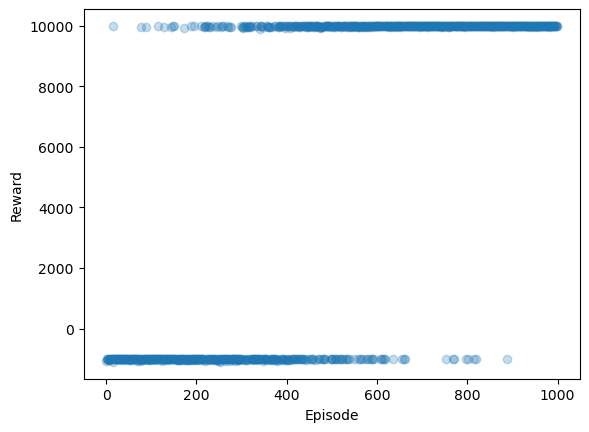

In [106]:
plt.scatter(list(range(len(agent.episode_rewards))), agent.episode_rewards, alpha = 0.25)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [109]:
agent.route_to_target(source, target)

[41,
 47,
 29,
 30,
 288,
 65,
 75,
 50,
 473,
 566,
 565,
 43,
 528,
 62,
 170,
 388,
 479,
 213,
 500,
 499,
 233,
 222,
 121,
 114,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 137,
 477,
 476,
 96,
 130,
 580,
 579,
 144,
 

In [142]:
def plot_all_paths_policy(G, policy, source, target):
    """_summary_

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha = 0.25
    )

    for i in G.nodes:
        dest = policy[i]
        
        # verify if there is a edge between i and dest, if not, continue
        if (i, dest) not in G.edges:
            continue
        
        plt.arrow(
            G.nodes[i]["x"], 
            G.nodes[i]["y"], 
            (G.nodes[dest]["x"] - G.nodes[i]["x"]) * 0.7, 
            (G.nodes[dest]["y"] - G.nodes[i]["y"]) * 0.7, 
            alpha = 0.8, 
            width = 0.0001
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]], 
        [G.nodes[source]["y"], G.nodes[target]["y"]], 
        color = ["green", "red" ],
        alpha = 1,
        s = 100
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color='red', label='Target')
    green_patch = mpatches.Patch(color='green', label='Source')
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    plt.show()

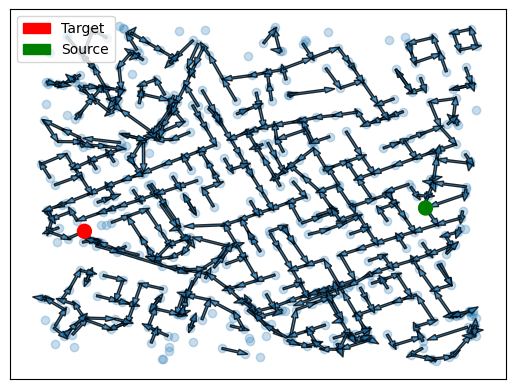

In [143]:
plot_all_paths_policy(G, agent.policy, source, target)

In [151]:
def plot_few_steps_policy(G, policy, source, target, steps=5):
    """_summary_

    :param G: network
    :type G: networkx.Graph
    :param policy: dict with nodes in keys and the action in values
    :type policy: dict
    :param source: source node
    :type source: int
    :param target: target node
    :type target: int
    :param steps: number of steps to plot, defaults to 5
    :type steps: int, optional
    """

    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha = 0.25
    )

    state = source
    for i in range(steps):
        dest = policy[state]
        
        # verify if there is a edge between i and dest, if not, continue
        if (state, dest) not in G.edges:
            continue
        
        plt.arrow(
            G.nodes[state]["x"], 
            G.nodes[state]["y"], 
            (G.nodes[dest]["x"] - G.nodes[state]["x"]) * 0.7, 
            (G.nodes[dest]["y"] - G.nodes[state]["y"]) * 0.7, 
            alpha = 0.8, 
            width = 0.0001
        )
        state = dest

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]], 
        [G.nodes[source]["y"], G.nodes[target]["y"]], 
        color = ["green", "red" ],
        alpha = 1,
        s = 100
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color='red', label='Target')
    green_patch = mpatches.Patch(color='green', label='Source')
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])
    plt.show()
    

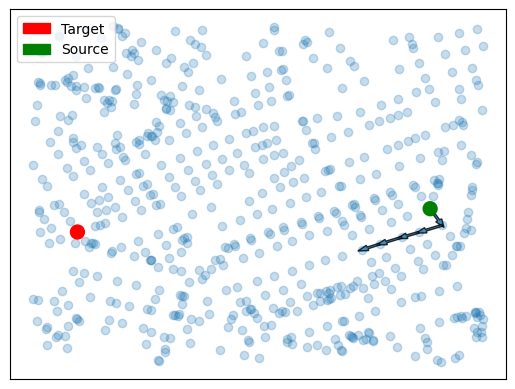

In [152]:
plot_few_steps_policy(G, agent.policy, source, target, steps=5)